In [105]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.read_csv('dataset/train_open.csv')

map_label = {'A':1, 'B':2, 'C':3, 'D':4, 'E':5, 'F':6}
col = ['32']
train[col] = train[col].applymap(map_label.get)

data_X = train.loc[:, train.columns != '32']
data_y = train.loc[:, train.columns == '32']

data_y = data_y.astype('int')
    
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.3, random_state=1234)

             1    2    3    4    5    6   7    8    9   10  ...   22  23  24  \
0     0.610390   88  130  111  115   83  60   98  102  108  ...  113  65  60   
1     0.538961   85  114  111  106   54  84   98  119  108  ...  108  85  84   
2     0.655844   99  129  131  120   77  68  111   82  122  ...  128  58  68   
3     0.642857  100  136  128  123  106  75  116  108  117  ...  122  79  66   
4     0.558442   91  149  114  114   75  93  111   90  115  ...  115  94  92   
...        ...  ...  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ..  ..   
3599  0.525974   83  119  101  105  116  87   99   85  105  ...  101  67  82   
3600  0.318182   65  127   74   70   54  53   53   89   78  ...   78  70  53   
3601  0.467532   87  136  104  100   71  71  103   71  104  ...  104  54  75   
3602  0.558442   91  149  114  101  111  85  102  123  102  ...  102  83  84   
3603  0.512987   94  148  101  105  108  67   97  125  115  ...  111  87  76   

      25   26  27        28   29   30  

In [102]:
# Model Comparison
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models = []
models.append(('LR', LogisticRegression(solver='lbfgs', max_iter=100000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('RF', RandomForestClassifier()))
models.append(('SVM', SVC()))

print(models)

[('LR', LogisticRegression(max_iter=500)), ('KNN', KNeighborsClassifier()), ('DT', DecisionTreeClassifier()), ('RF', RandomForestClassifier()), ('SVM', SVC())]


In [119]:
# Model Selection by Accuracy
seed = 7
results = []
names = []
scoring = 'accuracy'
for name, model in models:

    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle=True)
    cv_results = model_selection.cross_val_score(model, data_X, data_y.values.ravel(), cv=kfold, scoring=scoring)

    results.append(cv_results)
    names.append(name)
    msg = "%4s: %8f (%8f)" % (name, cv_results.mean(), cv_results.std())

    print(msg)

C:\Users\kc656\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\kc656\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

  LR: 0.833800 (0.022352)
 KNN: 0.824100 (0.019485)
  DT: 0.825486 (0.026830)
  RF: 0.891233 (0.021496)
 SVM: 0.854056 (0.025707)


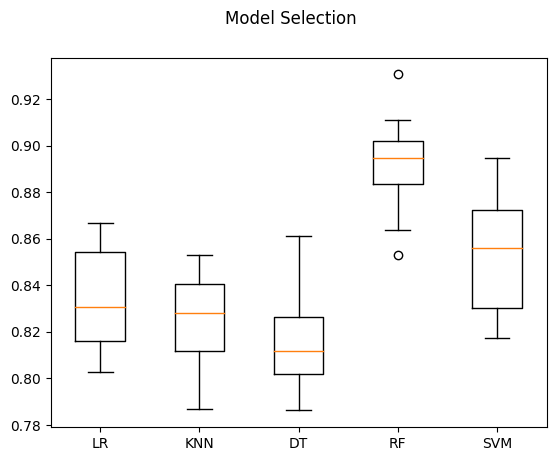

In [106]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.suptitle('Model Selection')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [107]:
from re import X
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import numpy as np
import pprint as pp

rf = RandomForestClassifier(random_state=1234)

max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)

param_grid = {
    'bootstrap': [True, False],
    'max_depth': max_depth,
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
}

random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, cv=5, n_jobs=-1, verbose=2)
random_search.fit(train_X, train_y)
pp.pprint(random_search.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


C:\Users\kc656\AppData\Roaming\Python\Python310\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': False,
 'max_depth': 110,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 1600}


In [110]:
test = pd.read_csv('dataset/test_open.csv')

print(test)

# best model
best_random_model = random_search.best_estimator_
best_random_predict = best_random_model.predict(test)

predict_str = []

for answer in best_random_predict:
    predict_str.append(answer)
    
# print(predict_str)    
pd.DataFrame(predict_str).to_csv('predict.csv')


             1   2    3    4    5    6   7    8    9   10  ...   22   23  24  \
0     0.376623  68  111   84   80   75  74   87   75   86  ...   75   67  67   
1     0.525974  89  134  104  109  112  67   95  120  112  ...  112  109  63   
2     0.344156  76  171   74   74   88  50   46   86   78  ...   82   66  53   
3     0.376623  45   95   66   73   57  56   53   77   65  ...   62   68  59   
4     0.512987  76  151   89   93   49  53   71   82   90  ...   90   92  53   
...        ...  ..  ...  ...  ...  ...  ..  ...  ...  ...  ...  ...  ...  ..   
1539  0.415584  65  144   82   82  103  67   75  114   86  ...   82   94  72   
1540  0.428571  80  144   93   90   77  75   88   76   97  ...   97   96  78   
1541  0.551948  85  129  113  113  113  93  107   91  108  ...  108   74  90   
1542  0.402597  59  140   74   78  107  64   77  114   83  ...   79   55  64   
1543  0.448052  74  118   94   94  109  80   94   77   96  ...   91   54  76   

      25   26  27        28  29   30   